<center><h1>INF580</h1></center>
<h3 align = 'center'>Sentence similarity using graph-of-words representation embeddings</h3>
<center><h5>Kniazev Leonid - Sattarov Tagir</h5></center>

**Project idea 2**: Create a graph-of-words from a sentence, enrich it with semantic distances, then use the DG methods in these lectures to embed the graph in a low-dimensional space; then evaluate sentence similarity using vector angles.

## 0. Import all the libraries

In [2]:
import sys
import string

import numpy as np
import numpy.linalg as la
import tqdm
import numba
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial.distance as dist
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import spacy

from amplpy import AMPL
import cvxpy as cp
import dgp_sdp

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. DATA PREPARATION

### 1.1 Datasets loading

In order to create a graph-of-words from text corpus, we will use two datasets.

The first is the pairs of english sentences and their similarities annotated by humans from SemEval-2017 contest (test set).

USE_TRAIN is used to enrich our graph with some adiitional data. We chose 1M words dataset of movies subtitles as additionnal data from "https://www.corpusdata.org/" for our graph of words (train set). It has a lot of different styles of coversations and has ~20 times more lemmas than the test set from SemEval-2017. 

Below you can find the 5 first pairs of sentences. As we can see they are not long and we can suppose that in this case graphs will not give us a lot of information about sentences.

At the same time, word-to-vec representation for a sentence will be meaningful and will keep information about most significant parts of sentences.



In [3]:
USE_TRAIN = True
DAT_FILE = 'dist_graph.dat'
with open('input.txt') as f:
    lines_test = [line.strip() for line in f]
with open('movies_text.txt') as f:
    lines_train = [line.strip() for line in f]

print(len(lines_test))
print(lines_test[:5])

250
['A person is on a baseball team.\tA person is playing basketball on a team.', 'Our current vehicles will be in museums when everyone has their own aircraft.\tThe car needs to some work', 'A woman supervisor is instructing the male workers.\tA woman is working as a nurse.', 'A bike is next to a couple women.\tA child next to a bike.', 'The group is eating while taking in a breathtaking view.\tA group of people take a look at an unusual tree.']


### 1.2 Preprocessing : remove punctuation, stopwords and lemmatize
We will work with sentences without punctuation marks. We also remove stopwords and lemmatize all the words.

Below we explain important variables that we used in our project:

"words" is a dictionary with all the lemmas that we have in our test and train sets. word["cat"] := index of "cat".

"test_words" is the same thing with lemmas only from the test set.

"sentences_test" is already cleaned test set with sentences represented as pairs of lists of word indexes.

"sentences_train" the same thing for the train set.

We use the information from the train dataset and we evaluate it on the test dataset.

In [4]:
stopwords_en = stopwords.words('english')
translation_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()
lemmas = set(wordnet.all_lemma_names())

words = dict()
test_words = dict()
sentences_test = list()

for line in lines_test:
    s1, s2 = line.split('\t')

    v1 = []
    v2 = []

    for s, v in [(s1, v1), (s2, v2)]:
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            words.setdefault(w, len(words))
            test_words.setdefault(w, len(test_words))
            v.append(words[w])

    sentences_test.append((v1, v2))

sentences_train = list()
if USE_TRAIN:
    for s in lines_train:
        v = []
    
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            
            words.setdefault(w, len(words))
            v.append(words[w])

        sentences_train.append(v)

In [5]:
print(len(words.keys()))
print(len(test_words.keys()))

18669
687


## 2. Main Algorithm

### 2.1 Make synonyms graph
First, we create a graph representing synonyms. For that, we use **wordnet** synonyms.

In **synonym_graph**, synonym_graph[i][j] is 1, iff the word words[i] and the word words[j] are synonyms.

In [6]:
synonym_graph = np.zeros((len(words), len(words)))

def set_of_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            syn_word = l.name()
            if syn_word in stopwords_en:
                continue
            syn_word = lemmatizer.lemmatize(syn_word)
            synonyms.append(syn_word)
    return set(synonyms)

for word, idx in words.items():
    for syn in set_of_synonyms(word):
        if syn not in words:
            continue
        syn_idx = words[syn]
        synonym_graph[idx][syn_idx] = 1
        synonym_graph[syn_idx][idx] = 1
if USE_TRAIN:
    synonym_graph = synonym_graph[:len(test_words), :len(test_words)]

In [7]:
print(synonym_graph.shape)

(687, 687)


We give you an example of a set of synonyms for the first word in the dictionary.

We see that there are 3 synonyms for "person" in the corpus.

In [8]:
print(list(words.keys())[0])
print(set_of_synonyms(list(words.keys())[0]))
print(sum(synonym_graph[0]))

person
{'somebody', 'soul', 'someone', 'individual', 'mortal', 'person'}
3.0


### 2.2 Make sliding window graph
Now, we create a sliding window graph.

**window_size** is a parameter. Each time two words words[i] and words[j] are in sliding window, we add 1 to window_graph[i][j].

In [9]:
window_size = 3

window_graph_train = np.zeros((len(words), len(words)))

for ss in sentences_test:
    for s in ss:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    for s in sentences_train:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    window_graph = window_graph_train[:len(test_words), :len(test_words)]
else:
    window_graph = window_graph_train

In [10]:
print(window_graph.shape)

(687, 687)


### 2.3 Make Spacy dependency tree graph

Here we create a graph representing sentence syntactic.

We work with **spaCy** dependency trees. **spaCy** uses the terms head and child to describe the words connected by a single arc in the dependency tree. Because the syntactic relations form a tree, every word has exactly one head. We can therefore iterate over the arcs in the tree by iterating over the words in the sentence.

In [11]:
dependency_graph = np.zeros((len(test_words), len(test_words)))
translation_table = str.maketrans('', '', string.punctuation)

nlp = spacy.load("en_core_web_lg")

for i in range(len(lines_test)):
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = ' '.join([w for w in sent1.split()])
    sent2 = ' '.join([w for w in sent2.split()])
    sent1 = nlp(sent1)
    sent2 = nlp(sent2)

    for s in [sent1, sent2]:
        for w in s: #iteration over the words in the sentence
            w1 = w.text.lower().translate(translation_table)
            w2 = w.head.text.lower().translate(translation_table)

            if (not w1 in stopwords_en) & (not w2 in stopwords_en) & (w.dep_ != "ROOT") & (w.dep_ != "punct"):
                w1 = lemmatizer.lemmatize(w1)
                w2 = lemmatizer.lemmatize(w2)
                if (w1 in test_words) & (w2 in test_words):
                    dependency_graph[test_words[w1]][test_words[w2]] += 1
                    dependency_graph[test_words[w2]][test_words[w2]] += 1

We show you the number of words in syntactic dependacies with "person" in the corpus.

In [12]:
print(sum(dependency_graph[0]))

19.0


### 2.4 Combine synonym, window graphs and dependency graph

Now, in order to use the information on synonyms, word order in sentences and syntactic dependencies, we put 3 graps together.

Then we complete distance matrix with shortest path lengths.

# To complete

In [13]:
print(synonym_graph.shape, window_graph.shape, dependency_graph.shape)
distances = 1 / (synonym_graph + window_graph + dependency_graph + 1)
#gr_max = np.max(synonym_graph + window_graph + dependency_graph)
#distances = gr_max - (synonym_graph + window_graph + dependency_graph) + 1
for i in range(distances.shape[0]):
    for j in range(distances.shape[0]):
        if distances[i][j] == 1:
            distances[i][j] = -1.0

np.fill_diagonal(distances, 0)

def floyd_warshall(dist):
    n = dist.shape[0]
    for u in tqdm.trange(n):
        for v in range(n):
            if dist[u][v] == -1.0:
                dist[u][v] = 10e6

    @numba.jit
    def h(dist, n, z):
        for u in range(n):
            for v in range(n):
                if (dist[u][v] > dist[u][z] + dist[z][v]):
                    dist[u][v] = dist[u][z] + dist[z][v]

    for z in tqdm.trange(n):
        h(dist, n, z)
        
    
floyd_warshall(distances)

if np.max(distances) == 10e6:
    print("Distances graph is not connected")
else:
    print("Distances graph is connected")

(687, 687) (687, 687) (687, 687)


100%|██████████| 687/687 [00:02<00:00, 277.98it/s]

Distances graph is connected


## 3 Distance Geometry

### 3.1 MDS


In this part we produce an approximate realisation of $x$.

We have an approximate EDMs $\tilde{D}$ from raw data completed with Floyd-Warshall algorithm. Then we compute an approximate Gram matrix:

$$ \tilde{G} = - \frac{1}{2} J \tilde{D}^2 J, $$

where $J = I_n - \frac{1}{n}\mathbb{1}\mathbb{1}^{T}$.

Having spectral decomposition of $\tilde{G} = P \tilde{\Lambda} P^{T}$, we find $\Lambda$ the PSD diagonal matrix closest to $\tilde{\Lambda}$.

$\Lambda$ is obtained from $\tilde{\Lambda}$ by zeroing negative components.

So, finally, $x = P \sqrt{\Lambda}$.

To move $\bar{x}$ to $0$, we reduce all the x by their mean. 

In [14]:
@numba.jit
def mds(matD, k):
    N = matD.shape[0]
    matJ = np.eye(N) - np.ones((N, N)) / N
    matG = -0.5 * matJ @ (matD ** 2) @ matJ
    vecL, matP = la.eigh(matG)
    vecL[vecL < 0] = 0
    return matP[:,-k:], vecL[-k:]

def embed_graph(distances, k):
    p, l = mds(distances, k)
    result = p @ np.diag(np.sqrt(l))
    result -= np.mean(result, axis=0)
    return result

In [15]:
#this function creates a .dat file in convinient for AMPL format based on subgraphs matrices
def print_dat(distances):
    with open(DAT_FILE, 'w') as f:
        #sys.stdout = f # Change the standard output to the file we created.
        f.write("param Kdim := 3;\nparam n := {};\nparam : E : c I :=\n".format(distances.shape[0]))
        for i in tqdm.trange(distances.shape[0]):
            for j in range(distances.shape[0]):
                if i-j==0:
                    continue
                f.write("{} {} {} 1\n".format(i+1, j+1, distances[i, j]))
        f.write(";")
        f.close()

### 3.2 General Pipeline

We can follow these steps:

1) We may use SDP relaxation for DGP. Its solution yields $n \times n$ PSD matrix $X^{*}$.

2) At the end, we need $n \times K$ realization matrix $x^{*}$, so we apply PCA to $X^{*}$, keep $K$ largest comps, get $x^{\prime}$.

3) As this yields solutions with errors, we use $x^{\prime}$ as starting point for local NLP solver.

For the first part, we may also use DDP, an approximation for SDP. In this case, DDP could be infeasible.

We may also use DualDDP which is a relaxation of SDP, and so, this is a relaxation of the original problem.

Three possible methods would be:

I. SDP -> PCA -> NLP

II. DDP -> PCA -> NLP

III. DualDDP -> PCA -> NLP


#### 3.2.1 SDP

#### SDP relaxation

Let's consider the system of quadratic equations

$$
\forall\{u, v\} \in E \quad\left\|x_{u}-x_{v}\right\|^{2}=d_{u v}^{2}
$$

We can add a new variable matrix $X$ s.t. $X_{i j} = x_i x_j$:

$$
\begin{aligned}
&\Rightarrow \forall\{i, j\} \in E \quad\left\|x_{i}\right\|_{2}^{2}+\left\|x_{j}\right\|_{2}^{2}-2 x_{i} \cdot x_{j}=d_{i j}^{2} \\
&\Rightarrow\left\{\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X &=x x^{\top}
\end{aligned}\right.
\end{aligned}
$$

Now we will add a relaxation, so we change $X-x x^{\top}=0$ to $X-x x^{\top} \succeq 0$.

Then we can replace $\operatorname{Schur}(X, x)=\left(\begin{array}{cc}
I_{K} & x^{\top} \\
x & X
\end{array}\right)\succeq 0$ by $$X \succeq 0,$$ because $x$ is not used elsewhere.

One of proposed methods gives an MP

$$
\begin{aligned}
\min F \bullet X =
\operatorname{tr}\left(F^{\top} X\right)
& \\
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X & \succeq 0
\end{aligned}
$$

We should choose the objective function, so we use a common one:

$$
\min \sum_{\{i, j\} \in E}\left(X_{i i}+X_{j j}-2 X_{i j}\right)
$$


In [16]:
def sdp(DAT_FILE, showplot=False):
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w

    ## MP formulation: vars, obj, constrs
    X = cp.Variable((n,n), PSD=True)

    cobj1 = sum([X[i,i] + X[j,j] - 2*X[i,j] for i in range(n) for j in G[i] if i<j])
    objective = cp.Minimize(cobj1)

    constraints = [X[i,i] + X[j,j] - 2*X[i,j] == G[i][j]**2 for i in range(n) for j in G[i] if i<j]
    prob = cp.Problem(objective, constraints)

    ## solve the problem
    prob.solve(solver=cp.SCS, verbose=True)

    objfunval = prob.value
    print("optimal obj. fun. value =", objfunval)

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    if X.value is None:
        A = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                A[i,j] = np.random.random()
        Y = dgp_sdp.MDS(A)
    else:
        Y = dgp_sdp.MDS(X.value)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    if X.value is None:
        xbar = dgp_sdp.PCA(A, K)
    else:
        xbar = dgp_sdp.PCA(X.value, K)
        
    ## report SDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("SDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("SDP largest distance error =", lderr1)

    from amplpy import Environment

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    ## plot results
    if dgp_sdp.showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()
    return (x, X.value is not None)

#### 3.2.2 DDP


SDP solver is a bottleneck in the Method 3.2.1. To avoid testing a matrix for SDP, we would like to work with LP problem instead.

For this reason, we introduce diagonally dominant (DD) matrices:

$n \times n$ symmetric matrix $X$ is DD if
$$
\forall i \leq n \quad X_{i i} \geq \sum_{j \neq i}\left|X_{i j}\right| \quad (*)
$$

Every DD matrix is PSD.

Before we had an MP such that

\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X & \succeq 0
\end{aligned}

Our approximation gives

\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} &=d_{i j}^{2} \\
X & \text{ is DD} \quad (*)
\end{aligned}

We may linearize (*) consrtaints by using an additional matrix variable $T$:

$$
(*) \Rightarrow \begin{aligned}
\forall i \leq n & \sum_{\substack{j \leq n \\
j \neq i}} T_{i j} \leq X_{i i} \\
& -T \leq X\leq T \\
& T \geq 0
\end{aligned}
$$

Considering the fact that DDP approximation could be infeasible, we will enlarge the feasible region.

We make a change:

$$
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j}=d_{i j}^{2}
$$

is now relaxed

$$
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} \geq d_{i j}^{2}
$$

An SDP problem becomes linear, but we need to use a specific objective function due to introduced relaxation:

$$
\begin{aligned}
&\min \sum_{\{i, j\} \in E}\left(X_{i i}+X_{j j}-2 X_{i j}\right)\\
&\begin{aligned}
\forall\{i, j\} \in E \quad X_{i i}+X_{j j}-2 X_{i j} & \geq d_{i j}^{2} \\
\forall i \leq n \quad \sum_{j \leq n, i \neq j} T_{i j} & \leq X_{i i} \\
-T \leq X & \leq T \\
T & \geq 0
\end{aligned}
\end{aligned}
$$

In [17]:
def ddp(DAT_FILE, showplot=False):
    # read instance
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## formulate and solve the dual DDP
    ddp = AMPL(Environment('../ampl'))
    ddp.read("dgp_ddp.mod")
    ddp.readData('./' + DAT_FILE)
    ddp.setOption('solver', dgp_sdp.LPsolver)
    ddp.solve()
    objfun = ddp.getObjective('push')
    objfunval = objfun.value()
    print("optimal obj. fun. value =", objfunval)
    Xvar = ddp.getVariable('X')
    X = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X[i,j] = Xvar[i+1,j+1].value()

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = dgp_sdp.MDS(X)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X, K)

    ## report dualDDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("DDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("DDP largest distance error =", lderr1)

    ## refine solution with a local NLP solver
    nlp = AMPL(Environment('../ampl'))
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    ## plot results
    if showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()

#### 3.2.3 Dual Cone DDP

Let C be a cone if:
$$\forall A, B \in C, \alpha, \beta \geq 0 \quad \alpha A+\beta B \in C$$
and $C^{*}=\{y \mid \forall x \in C \quad \langle x, y\rangle \geq 0\}$ its dual cone.

We will use $\mathcal{X}_{\mathbb{D D}}=\left\{e_{i} \mid i \leq n\right\} \cup\left\{\left(e_{i} \pm e_{j}\right) \mid i<j \leq n\right\}$ where $e_i$ is the $i^{th}$ basis element of $\R^n$.

$\mathcal{X}_{\mathbb{D D}}$ finitely generates the set of Diagonally Dominant matrices which is denoted as $\mathbb{D D}$. We mention that $|\mathcal{X}_{\mathbb{D D}}| = |O(n^2)|$

Using the finitely generated dual cone theorem, we know that $$DD^* = \left\{Y\mid \forall x \in \mathcal{X}_{\mathbb{D D}}\left(Y \bullet x x^{\top} \geq 0\right) = \left(x^{\top} Y x \geq 0\right) \right\}$$

As $\mathbb{D D}^{*} \supset \mathbb{P S D}$, we may use an relaxation of SDP.

So, we change the formulation of SDP for our DGP and we take 
condition $\forall v \in \mathcal{X}_{\mathbb{D D}}~~ v^{\top} X v \geq 0$ instead of $ X \succeq 0$. 

And the final Dual cone DDP formulation for DGP is
$$\min \sum_{\{i, j\} \in E}\left(X_{i i}+X_{j j}-2 X_{i j}\right)\\
\forall\{i, j\} \in E ~~~~  X_{i i}+X_{j j}-2 X_{i j} =d_{i j}^{2}  \\
\forall i \leq n \quad X_{i i} \geq 0\\
\forall\{i, j\} \notin E \quad X_{i i}+X_{j j}-2 X_{i j} \geq 0\\
\forall i<j \quad X_{i i}+X_{j j}+2 X_{i j} \geq 0
$$


In [18]:
def dualddp(DAT_FILE, showplot=False):
    # read instance
    (Kdim, n, E) = dgp_sdp.readDat('./' + DAT_FILE)

    ## construct weighted vertex neighbourhoods from edges
    G = {i:dict() for i in range(n)}
    for e in E:
        i = e[0]-1 # first vertex
        j = e[1]-1 # second vertex
        w = e[2] # edge weight
        if i > j:
            t = i
            i = j
            j = t
        G[i][j] = w 

    ## formulate and solve the dual DDP
    dualddp = AMPL()
    dualddp.read("dgp_dualddp.mod")
    dualddp.readData('./' + DAT_FILE)
    dualddp.setOption('solver', dgp_sdp.LPsolver)
    dualddp.solve()
    objfun = dualddp.getObjective('push')
    objfunval = objfun.value()
    print("optimal obj. fun. value =", objfunval)
    Xvar = dualddp.getVariable('X')
    X = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            X[i,j] = Xvar[i+1,j+1].value()

    ## retrieve realization in K dimensions
    print("ambient dimension n =", n)
    Y = dgp_sdp.MDS(X)
    K = Y.shape[1]
    print("found relaxed embedding in natural dimension K =", K)
    if K not in {2,3}:
        if K < 2:
            K = 2
        elif K > 3:
            K = 3
    print("now projecting to", K, "principal dimensions")
    xbar = dgp_sdp.PCA(X, K)

    ## report dualDDP solution statistics
    mderr1 = dgp_sdp.mde(xbar, G)
    print("dualDDP mean distance error =", mderr1)
    lderr1 = dgp_sdp.lde(xbar, G)
    print("dualDDP largest distance error =", lderr1)

    ## refine solution with a local NLP solver
    nlp = AMPL()
    nlp.read("dgp.mod")
    nlp.readData('./' + DAT_FILE)
    nlp.setOption('solver', dgp_sdp.NLPsolver)
    xvar = nlp.getVariable('x')
    for i in range(n):
        for k in range(K):
            xvar[i+1,k+1].setValue(xbar[i,k])
    nlp.solve()
    xvar = nlp.getVariable('x')
    xval = xvar.getValues()
    x = np.zeros((n,K))
    for i in range(n):
        for k in range(K):
            x[i,k] = xvar[i+1,k+1].value()

    # report NLP solution statistics
    mderr2 = dgp_sdp.mde(x, G)
    print("NLP mean distance error =", mderr2)
    lderr2 = dgp_sdp.lde(x, G)
    print("NLP largest distance error =", lderr2)

    ## plot results
    if showplot:
        if K == 2:
            plt.scatter(x[:,0], x[:,1])
            plt.plot(x[:,0], x[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(x[:,0], x[:,1], x[:,2])
            ax.plot(x[:,0], x[:,1], x[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')    
        plt.show()

## 4 Results

### 4.1 Visualisation in 2D 

Next plot gives us a visualisation of the result on 2D. Then we will use k = 20 dimensions.

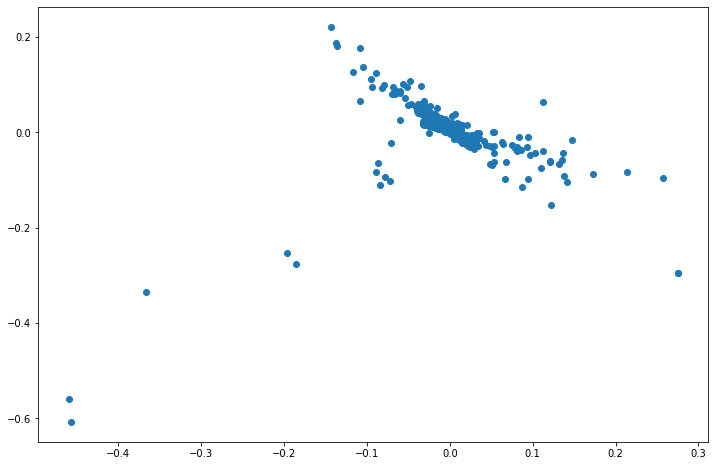

In [19]:
k=20
word_to_vec = embed_graph(distances, k)

plt.figure(figsize=(12,8))
plt.scatter(*embed_graph(distances, 2).transpose())
plt.show()

#### Application of methods for  for subgraphs l


In [20]:
print_dat(distances)
sdp_distances, result = sdp(DAT_FILE, showplot=False)


100%|██████████| 687/687 [00:01<00:00, 509.01it/s]


In [ ]:
print(result)
#print(sdp_distances)

In [ ]:
N_printed_sents = 1
nlp = spacy.load('en_core_web_lg')
with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])
ampl_res = []
idx = []

if False:
    for i, (s1, s2) in enumerate(sentences_test):
        
        subgraph1 = distances[np.ix_(s1, s1)]
        subgraph2 = distances[np.ix_(s2, s2)]
        print_dat(subgraph1)
        result1, suc1 = sdp(DAT_FILE, showplot=False)
        print_dat(subgraph2)
        result2, suc2 = sdp(DAT_FILE, showplot=False)
        if not (suc1 & suc2):
            ampl_res.append(0)
            continue
        v1 = np.mean(result1, axis=0)
        v2 = np.mean(result2, axis=0)
        if v1.shape != v2.shape:
            ampl_res.append(0)
            continue
        d = (cosine_similarity([v1], [v2])[0,0]+1)/2.
        ampl_res.append(d)
        print(i, "{:1.8f} {:1.8f}".format(train[i] / 5, d), lines_test[i], sep='\t')
        idx.append(i)
        if i > N_printed_sents:
            break

In [ ]:
p_xy = np.corrcoef(np.array(train)[idx], np.array(ampl_res)[idx])
print("p_xy spacy train = ", p_xy[1, 0])

p_xy spacy train =  -0.052242227990490366


In [ ]:
print(np.array(train)[idx]/5.0, np.array(ampl_res)[idx], idx)

[0.04 0.2  0.4  0.6  0.36 0.44 0.72 0.64] [1.         0.26059313 0.37966198 0.21561828 0.         0.97410406
 0.5164724  0.99999965] [1, 2, 3, 11, 13, 16, 17, 23]


CPLEX 20.1.0.0: optimal solution; objective 5931.370147
0 dual simplex iterations (0 in phase I)
19 barrier iterations
optimal obj. fun. value = 5931.37014674213
ambient dimension n = 38
found relaxed embedding in natural dimension K = 37
now projecting to 3 principal dimensions
DDP mean distance error = 1.8093311550580489
DDP largest distance error = 4.126467955100351
Cannot find "ipopt"
NLP mean distance error = 1.8093315550832791
NLP largest distance error = 4.126468374504312
OUTLABELS:mp,projmethod,objX,mdeX,ldeX,mdex,ldex
OUT:sdp,PCA,5931.370,1.809,4.126,1.809,4.126


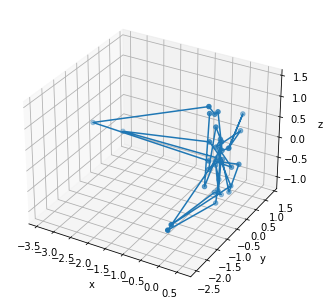

In [ ]:
ddp('tiny_gph.dat', showplot=True)

#### old code

In [ ]:
N_printed_sents = 200
nlp = spacy.load('en_core_web_lg')

with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])
idx = []
result_subgraph = []
for i, (s1, s2) in enumerate(sentences_test):
    if len(s1) <3 or len(s2) < 3:
        result_subgraph.append(0)
        continue
    v1 = np.mean(word_to_vec[s1,:], axis=0)
    v2 = np.mean(word_to_vec[s2,:], axis=0)
    d = (cosine_similarity([v1], [v2])[0,0]+1)/2.


    #MDS on subgraph
    subgraph1 = distances[np.ix_(s1, s1)]
    subgraph2 = distances[np.ix_(s2, s2)]
    embed_subgraph1 = graph_embed(subgraph1, 3)
    embed_subgraph2 = graph_embed(subgraph2, 3)
    vsub1 = np.mean(embed_subgraph1, axis=0)
    vsub2 = np.mean(embed_subgraph2, axis=0)
    d2 = (cosine_similarity([v1], [v2])[0,0]+1)/2.
    result_subgraph.append(d2)

    #print(d.shape)
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = nlp(sent1)
    sent1 = nlp(' '.join([str(t) for t in sent1 if not t.is_stop]))
    sent2 = nlp(sent2)
    sent2 = nlp(' '.join([str(t) for t in sent2 if not t.is_stop]))
    #sent1 = nlp(' '.join([word for word in sent1 if word not in english_stopwords]))
    #sent2 = nlp(' '.join([word for word in sent2 if word not in english_stopwords]))
    similarity = sent1.similarity(sent2)
    #if similarity < 0.4:
    print(i, "{:1.8f} {:1.8f} {:1.8f}".format(train[i] / 5, d, d2, similarity), lines_test[i], sep='\t')
    if i > N_printed_sents:
        break

NameError: name 'spacy' is not defined

In [ ]:
our_simlarity_n = 1-np.array([dist.cosine(np.mean(word_to_vec[s1,:], axis=0), np.mean(word_to_vec[s2,:], axis=0)) for (s1, s2) in sentences_test])/2
spacy_similarity_n = np.array([nlp(' '.join([str(t) for t in nlp(sent2) if not t.is_stop])).similarity(nlp(' '.join([str(t) for t in nlp(sent1) if not t.is_stop]))) for (sent1, sent2) in [s.split('\t') for s in lines_test]])
print(spacy_similarity_n[:10])

print(our_simlarity_n[:10])



[0.9237369  0.63757388 0.8347624  0.8160544  0.82062957 0.9536833
 0.81375333 0.79174104 0.82175876 1.        ]
[0.92187823 0.35590817 0.52993919 0.97916754 0.28898951 0.99434384
 0.69519802 0.67610976 0.51193864 0.98772491]


### 4.2 Pearson correlation coefficient
To estimate the quality of models we will use this coefficient, which is calculated as follows:
$$p_{XY} = \frac{\sigma_{XY}}{\sigma_X \cdot \sigma_Y}$$
where $p_{XY}$ is the Pearson correlation coefficient, $\sigma_Y, \sigma_X$ are standart deviations of $Y$ and $X$, and $\sigma_{XY}$ is the covariance between $X$ and $Y$ 


In [ ]:
#we normalize all the 
p_xy = np.corrcoef(train, spacy_similarity_n)
print("p_xy spacy train = ", p_xy[1, 0])
p_xy = np.corrcoef(our_simlarity_n, spacy_similarity_n)
print("p_xy spacy our_simlarity_n = ", p_xy[1, 0])
p_xy = np.corrcoef(train, our_simlarity_n)
print("p_xy our_simlarity_n train = ", p_xy[1, 0])


p_xy spacy train =  0.7131287525074835
p_xy spacy our_simlarity_n =  0.5395828515504087
p_xy our_simlarity_n train =  0.5113422409775331


### 4.3 Our comments on the results

As we can see the best quality we have for spacy built-in function which uses word-to-vec representation. The second best and not too far from spacy, is our implementation of MDS on the graph representation of all the sentences.
As it was expected 

## 5 Further researches and possible improvements

As an improvement one could use all the DG methods on the graph with <b>all the words</b> as in the MDS. 

Another problem that we had is that words from the dataset could close after lemmatizing when before they were not, and this problem is more pronounced when we have "strange" vocabulary as we have in our additional dataset. 

### Some other metrics(to remove)

In [ ]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

0.16965264574028385
0.007678251653702461
0.7751361274991766


In [ ]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

print('n')
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.16965264574028385
0.007678251653702461
0.7751361274991766
n
0.10256349803064416
0.2299975111999682
0.06236852391124974
0.02809066985255107
0.08105832959999999


In [ ]:
 # _n for normalized
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.10256349803064416
0.2299975111999682
0.06236852391124974
0.02809066985255107
0.08105832959999999
